# DIO （ピッチ抽出）の使い方

In [2]:
# %matplotlib widget
import soundfile as sf
from espnet2.asr.frontend.default import DefaultFrontend
from espnet2.asr.specaug.specaug import SpecAug
import torch
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import librosa
import math
import warnings

In [3]:
# スペクトルなどを表示するプログラム
def hz_to_mel_index(freq, n_mels=80, fmin=0, fmax=8000, htk=False):
    """周波数からメルチャネルのインデクス（実数値）を計算する．

    Args:
        freq (float or iterable): 周波数 [Hz] またはそのリスト
        n_mels (int): メルフィルタバンクの数
        fmin (float): メルスペクトログラムの最低周波数 [Hz]
        fmax (float): メルスペクトログラムの最大周波数 [Hz]
        htk (bool): HTK メルフィルタバンクを使うかどうか
    
    Returns:
        float or list: メルチャネルのインデクス（実数値）またはそのリスト
    """  
    def single_hz_to_mel_index(freq):
        if freq <= 0:
            return 0
        if freq > fmax:
            return n_mels
        mel_min = librosa.hz_to_mel(fmin, htk=htk)
        mel_max = librosa.hz_to_mel(fmax, htk=htk)
        mel = librosa.hz_to_mel(freq, htk=htk)
        idx = (mel - mel_min) / (mel_max - mel_min) * n_mels
        return idx

    if hasattr(freq, '__iter__'):
        return [single_hz_to_mel_index(f) for f in freq]
    else:
        return single_hz_to_mel_index(freq)

In [4]:
def show_mel_spectrogram(mel, ax, cmap="viridis", sr=16000, hop_length=160, fmin=0, fmax=8000, htk=False, show_xaxis=True):
    """メルスペクトログラムを表示する．

    Args:
        mel (numpy.ndarray): メルスペクトログラム
        ax (matplotlib.axes.Axes): 表示する Axes
        cmap (str): カラーマップ
        sr (int): サンプリング周波数 [Hz]
        hop_length (int): フレームの間隔
        fmin (float): メルスペクトログラムの最低周波数 [Hz]
        fmax (float): メルスペクトログラムの最大周波数 [Hz]
        htk (bool): HTK メルフィルタバンクを使うかどうか
    """    
    ax.imshow(mel, aspect="auto", origin="lower", cmap=cmap, interpolation='none',
              extent=(0, mel.shape[1]*hop_length/sr, 0, mel.shape[0]))
    
    n_mel = mel.shape[0]
    
    yticks_labels = [0] + [2**i for i in range(8, int(math.log2(sr/2))+1)] + [int(sr / 2)]
    yticks_possitions = hz_to_mel_index(yticks_labels, n_mel, fmax=sr / 2, htk=htk)

    ax.set_yticks(yticks_possitions, labels=yticks_labels)
    ax.set_ylim([0, n_mel])
    ax.set_ylabel("Frequency [Hz]")
    
    if show_xaxis:
        ax.set_xlabel("Time [sec]")
    else:
        ax.set_xticks([])

In [5]:
def show_mel_spectrogram_with_sound(sound, mel, ax_sound, ax_mel, cmap="viridis", sr=16000, hop_length=160, fmin=0, fmax=8000, htk=False, show_mel_xaxis=False):
    show_mel_spectrogram(mel, ax_mel, cmap=cmap, sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax, htk=htk, show_xaxis=show_mel_xaxis)
    librosa.display.waveshow(sound, sr=sr, ax=ax_sound, color="blue", x_axis="time")

## 基本的な使い方

In [6]:
from espnet2.tts.feats_extract.dio import Dio 

In [7]:
# インスタンスの作成
dio = Dio(
    fs=16000,       # サンプリング周波数
    n_fft=1024,     # FFT点数
    hop_length=128, # フレームの間隔
    use_token_averaged_f0=False, # トークンごとの代表F0使うか（今回の場合は常にFalse）
    use_continuous_f0=False, # 連続的なF0を使うか（今回の場合は常にFalse）
    use_log_f0=True # 対数F0を使うか
)

In [8]:
# soundfile の read 関数で音声を読み込む．
# 戻り値は，音声信号の numpy.ndarray とサンプリング周波数．
filename = '../../soundfiles/uec0006r_014.wav'
sound, fs = sf.read(filename)

In [9]:
# torch.Tensor に変換
sound_tensor = torch.tensor(sound.astype(np.float32))
# バッチサイズ相当の次元を追加
sound_tensor = sound_tensor.unsqueeze(0)

In [10]:
sound_lengths = torch.tensor([len(sound)])

In [11]:
f0, f0_lengths = dio(sound_tensor, torch.tensor([len(sound)]))

(3.912023005428146, 6.551080335043404)

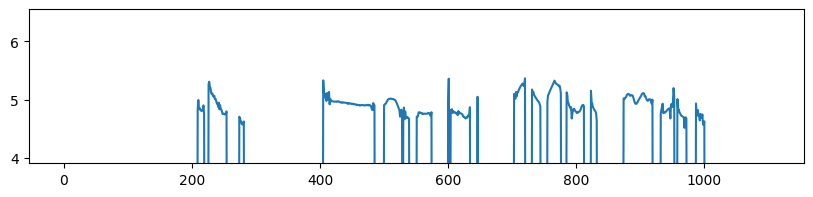

In [12]:
plt.figure(figsize=(10, 2))
plt.plot(f0[0].numpy())
plt.ylim([math.log(50), math.log(700)])

## 抑揚成分の計算をしてみる

In [13]:
def f0process(f0, num_sub=4):
    """F0系列を受け取り, サブサンプル, および抑揚の計算を行う

    Args:
        f0: F0系列. shapeは(フレーム数, )
        num_sub: サブサンプルさい, いくつのフレームでまとめるか
    
    Returns:
        サブサンプルされたF0系列, shapeは（フレーム数//4+1, 3）
        1列目には代表値が入る
        2列目には1次近似した際の傾きが入る
        3列目には1次近似した際の切片が入る
    """
    # num_subは2以上の整数でなければならない
    assert num_sub >= 2 and isinstance(num_sub, int), "num_sub must be an integer greater than or equal to 2"

    # 長さがnum_subの倍数になるようにパディング
    if f0.shape[0] % num_sub != 0:
        pad = num_sub - f0.shape[0] % num_sub
        f0 = np.concatenate([f0, np.zeros(pad)], axis=0)

    # サブサンプルの準備
    f0s = f0.reshape(-1, num_sub)

    # 代表値（f0p）の計算
    if num_sub % 2 == 0:
        # num_subが偶数の場合は，中間の２つの値の平均を取る
        # ただし，0は平均の計算に含めず，両者0の場合は0を返す
        f0p = f0s[:, num_sub//2-1:num_sub//2+1].copy()
        f0p[f0p == 0] = np.nan
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            f0p = np.nanmean(f0p, axis=1)
        f0p[np.isnan(f0p)] = 0
    else:
        # num_subが奇数の場合は，単純に中間の値を取る
        f0p = f0s[:, num_sub//2].copy()

    # 1次近似の計算
    f0dy = f0s.copy()
    f0dx = np.arange(num_sub) - (num_sub - 1) / 2
    f0ds = []
    for i in range(f0dy.shape[0]):
        nonzero_count = np.sum(f0dy[i] > 0)
        if nonzero_count > num_sub / 2:
            dx = f0dx[f0dy[i] > 0]
            
            dy = f0dy[i][f0dy[i] > 0]
            f0ds.append(np.polyfit(dx, dy, 1))
        else:
            f0ds.append([0, 0])
    f0ds = np.stack(f0ds)

    result = np.concatenate([f0p.reshape(-1, 1), f0ds], axis=1)

    return result


In [14]:
f0p = f0process(f0[0, :, 0])

In [15]:
def plot_processed_f0(f0, processed_f0, ax, fs=16000, hop_length=128, num_sub=4):
    pr = hop_length / fs # フレーム間隔
    t = np.arange(f0.shape[0]) * hop_length / fs    

    pp = hop_length / fs * num_sub # サブサンプル後のフレーム間隔
    tp = (np.arange(processed_f0.shape[0]) + 0.5) * pp

    ax.plot(t, f0, 'k-', linewidth=0.5, label="raw f0")
    ax.plot(tp, processed_f0[:, 0], 'o', color='none', markeredgecolor='k', label="processed f0")
    for i in range(processed_f0.shape[0]):
        if processed_f0[i, 1] != 0:
            a = processed_f0[i, 1] # 傾き
            b = processed_f0[i, 2] # 切片
            if b <= 0:
                continue
            xx = [tp[i] - pp * 0.4, tp[i] + pp * 0.4]
            yy = [a * -0.4 + b, a * 0.4 + b]
            if a >= 0:
                ax.plot(xx, yy, 'r-')
            else:
                ax.plot(xx, yy, 'b-')
    ax.set_ylim([math.log(50), math.log(700)])
    ax.set_ylabel("log F0")
    ax.set_xlabel("Time [sec]")

(5.0, 8.0)

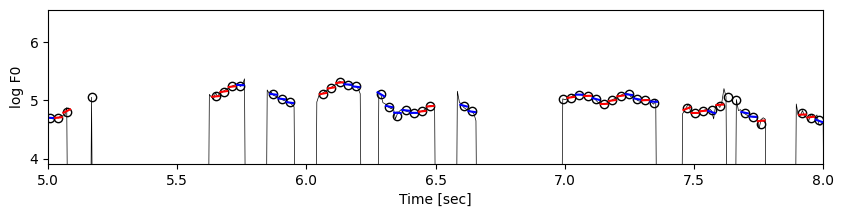

In [16]:
plt.figure(figsize=(10, 2))
plot_processed_f0(f0[0, :, 0], f0p, plt.gca())
plt.ylim([math.log(50), math.log(700)])
plt.xlim([5, 8])

In [17]:
frontend = DefaultFrontend(fs=16000, n_fft=1024, hop_length=128, win_length=800, n_mels=160, htk=False)
mspec, mspec_lengths = frontend(sound_tensor, sound_lengths)

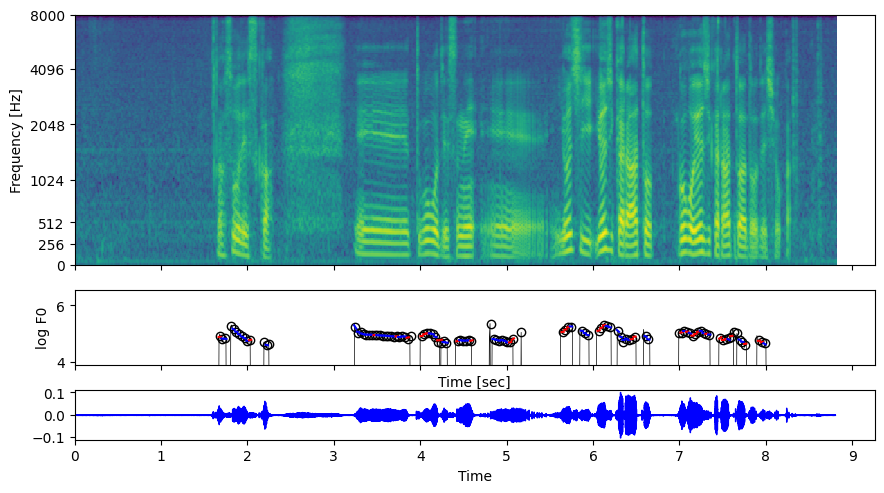

In [19]:
_, ax = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
show_mel_spectrogram_with_sound(sound, mspec[0].numpy().T, ax[2], ax[0], 
                                sr=fs, hop_length=128, fmin=0, fmax=8000, htk=False)
plot_processed_f0(f0[0, :, 0], f0p, ax[1])
# ax[0].set_xlim([2, 5])
ax[0].set_position([0.1, 0.45, 0.8, 0.5])
ax[1].set_position([0.1, 0.25, 0.8, 0.15])
ax[2].set_position([0.1, 0.1,  0.8, 0.1])

display.display(display.Audio(sound, rate=fs))